# Hidden Markov Model: An implementation for shorting the volatility

In this notebook, we will implement an Hidden Markov Model in order to identify in which state of volatility we are right now to sell the volatility on the market. For further information on this topic please refer to the EMSE paper which describes the strategy.
An HMM is fully defined by: 

$$
\lambda = (\pi, A, B)
$$

First we will need initial distribution:

$$
\pi_i = P(q_1 = i)
$$
This is the prior belief about the regime at start.

The transition matrix of the Markov process is also relevant: 

$$
A =
\begin{pmatrix}
a_{11} & \cdots & a_{1N} \\
\vdots & \ddots & \vdots \\
a_{N1} & \cdots & a_{NN}
\end{pmatrix}
$$


Where $a_{ii}$ is the regime persistence of the state i and the expected duration of regime i is: $\mathbb{E}[T_i] = \frac{1}{1 - a_{ii}}$

Finally, we need the emission distribution B, if gaussian (which can be requestionned) $O_t \mid q_t = i \sim \mathcal{N}(\mu_i, \Sigma_i)$. We interpret this as each regime has: mean return, volatility, covariance structure. This is how the model learns regime.


We have here a lot of paramters we will try to optimize:

* duration between two observation
* how to cal

We also need to have a good data quality:

* Missing values
* Outliers

Hidden Markov Model:

* Gaussian emission densities with full covariance
* Baum-Welch (EM) algorithm for parameter estimation
* Viterbi decoding for most likely state sequence
* Model selection via AIC/BIC criteria

Let's optimize this hyper parameters:

* number of different states
* Normal law only?
* 

  

source:

- https://github.com/I-am-Uchenna/regime-allocation-strategy
- https://dms.umontreal.ca/~augusty/FHMV_paper.pdf

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import threading
import asyncio
import scipy
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

from ib_insync import *
from ib_insync import IB, Stock, util
from ib_insync import Future
from ib_insync import Stock
from ib_insync import Option
from ib_insync import Bond
from ib_insync import Forex
from ib_insync import Index
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D 
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
import plotly.graph_objects as go
import plotly.io as pio
from scipy.integrate import quad
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')

pio.renderers.default = "notebook"
%matplotlib widget
%matplotlib ipympl
import pyfolio as pf

In [3]:
%pip install pyfolio-reloaded


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.4 MB/s  0:00:00m 5.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 6.8 MB/s  0:00:007.0 MB/s eta 0:00:01:01
  Created wheel for peewee: filename=peewee-3.17.3-py3-none-any.whl size=138489 sha256=4f7ac79e55853798759f43914135b53bfd18d51010cce8c1fb24ae5640402fc2
  Stored in directory: /Users/eliaslauzon/Library/Caches/pip/wheels/bf/f8/29/6fa5736fcdd506fda6330ade6ffc55e12ef49ff407c48a853a
Successfully built peewee
  Attempting uninstall: peewee
    Found existing installation: peewee 3.18.3
    Uninstalling peewee-3.18.3:
      Successfully uninstalled peewee-3.18.3━━━━━━━━━━ 0/4 [peewee]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pyfolio-reloaded]

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/

# Data

In [ ]:
ib = IB()
util.startLoop()
await ib.connectAsync('127.0.0.1', 7496, clientId=2) # Don't forget to change the client ID

Let's implement our strategie for the Euro stoxx 50 and we will adapt the same methodology for EU/US small and mid caps. First we will trade option on Euro stoxx 50, as a first implementation, we will not consider correlation between assets.

In [2]:
VIX = yf.Ticker("^VIX")
VVIX = yf.Ticker("^VVIX")

VIX_historical = VIX.history(start="2007-01-03", end="2026-02-03", interval="1D")


VVIX_historical = VVIX.history(start="2007-01-03", end="2026-02-03", interval="1D")



VIX_log_returns = pd.DataFrame(np.log(VIX_historical["Close"] / VIX_historical["Close"].shift(1)))
VIX_log_returns = VIX_log_returns.dropna()


In [3]:
VIX_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03 00:00:00-05:00,12.160000,12.750000,11.530000,12.040000,0,0.0,0.0
2007-01-04 00:00:00-05:00,12.400000,12.420000,11.280000,11.510000,0,0.0,0.0
2007-01-05 00:00:00-05:00,11.840000,12.250000,11.680000,12.140000,0,0.0,0.0
2007-01-08 00:00:00-05:00,12.480000,12.830000,11.780000,12.000000,0,0.0,0.0
2007-01-09 00:00:00-05:00,11.860000,12.470000,11.690000,11.910000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-27 00:00:00-05:00,16.020000,16.370001,15.740000,16.350000,0,0.0,0.0
2026-01-28 00:00:00-05:00,16.090000,17.180000,16.049999,16.350000,0,0.0,0.0
2026-01-29 00:00:00-05:00,16.040001,19.740000,16.020000,16.879999,0,0.0,0.0


In [4]:
VVIX_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03 00:00:00-05:00,87.629997,87.629997,87.629997,87.629997,0,0.0,0.0
2007-01-04 00:00:00-05:00,88.190002,88.190002,88.190002,88.190002,0,0.0,0.0
2007-01-05 00:00:00-05:00,90.169998,90.169998,90.169998,90.169998,0,0.0,0.0
2007-01-08 00:00:00-05:00,92.040001,92.040001,92.040001,92.040001,0,0.0,0.0
2007-01-09 00:00:00-05:00,92.760002,92.760002,92.760002,92.760002,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-27 00:00:00-05:00,99.910004,101.260002,97.980003,101.260002,0,0.0,0.0
2026-01-28 00:00:00-05:00,101.489998,107.839996,99.000000,100.459999,0,0.0,0.0
2026-01-29 00:00:00-05:00,102.919998,111.919998,101.680000,101.760002,0,0.0,0.0


In [5]:
# We can see that there are missing values of the VVIx, we will as a first implementation, replace them by the mean of the values of the next and the previous day

missing_in_vvix = VIX_historical.index.difference(VVIX_historical.index)
print("Missing dates in VVIX:", missing_in_vvix)

VVIX_full = VVIX_historical.reindex(VIX_historical.index)

VVIX_full["Close"] = VVIX_full["Close"].interpolate(method="linear")


Missing dates in VVIX: DatetimeIndex(['2010-11-11 00:00:00-05:00', '2019-07-05 00:00:00-04:00',
               '2020-06-11 00:00:00-04:00', '2021-01-22 00:00:00-05:00',
               '2021-02-17 00:00:00-05:00', '2021-05-05 00:00:00-04:00',
               '2021-05-11 00:00:00-04:00', '2021-05-20 00:00:00-04:00',
               '2021-05-25 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', freq=None)


In [6]:
missing_in_vvix = VIX_historical.index.difference(VVIX_full.index)
print("Missing dates in VVIX:", missing_in_vvix)

Missing dates in VVIX: DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Date', freq=None)


In [7]:
VIX = VIX_historical


VVIX = VVIX_full



<Axes: xlabel='Date'>

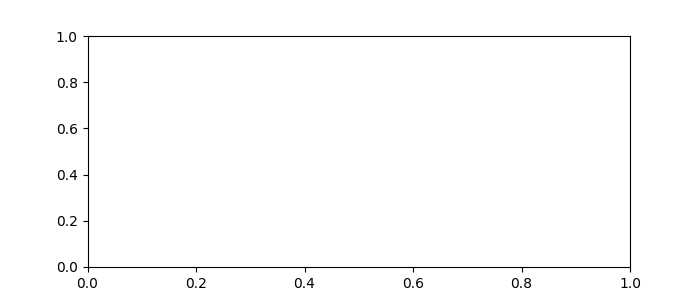

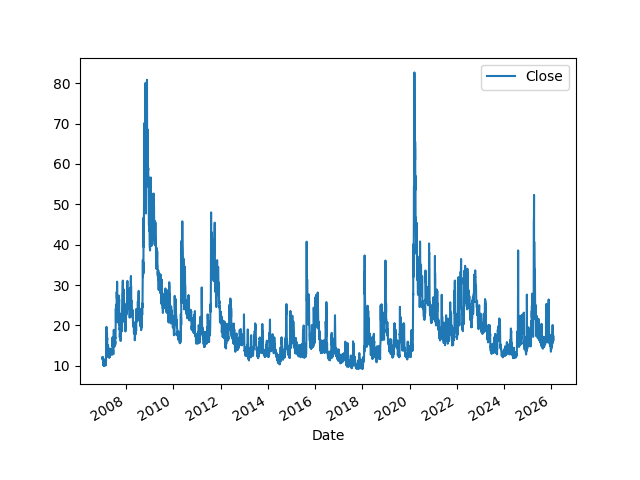

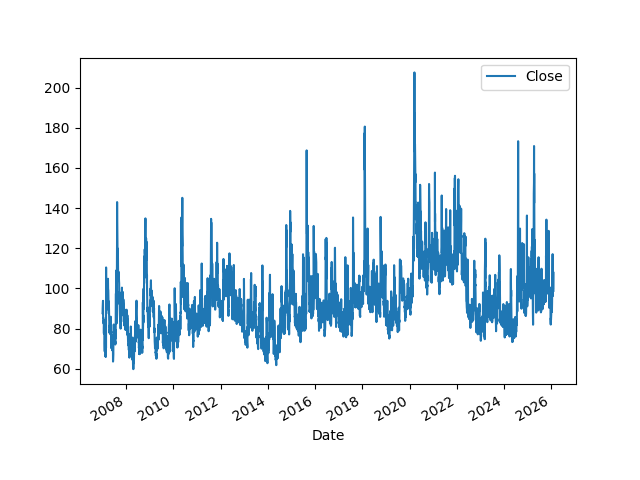

In [8]:
fig, ax = plt.subplots(figsize=(7,3))
VIX.plot( y = "Close")
VVIX.plot( y = "Close")






In [9]:
VIX, VVIX

(                                Open       High        Low      Close  Volume  \
 Date                                                                            
 2007-01-03 00:00:00-05:00  12.160000  12.750000  11.530000  12.040000       0   
 2007-01-04 00:00:00-05:00  12.400000  12.420000  11.280000  11.510000       0   
 2007-01-05 00:00:00-05:00  11.840000  12.250000  11.680000  12.140000       0   
 2007-01-08 00:00:00-05:00  12.480000  12.830000  11.780000  12.000000       0   
 2007-01-09 00:00:00-05:00  11.860000  12.470000  11.690000  11.910000       0   
 ...                              ...        ...        ...        ...     ...   
 2026-01-27 00:00:00-05:00  16.020000  16.370001  15.740000  16.350000       0   
 2026-01-28 00:00:00-05:00  16.090000  17.180000  16.049999  16.350000       0   
 2026-01-29 00:00:00-05:00  16.040001  19.740000  16.020000  16.879999       0   
 2026-01-30 00:00:00-05:00  18.719999  19.270000  16.670000  17.440001       0   
 2026-02-02 00:0

# HMM:

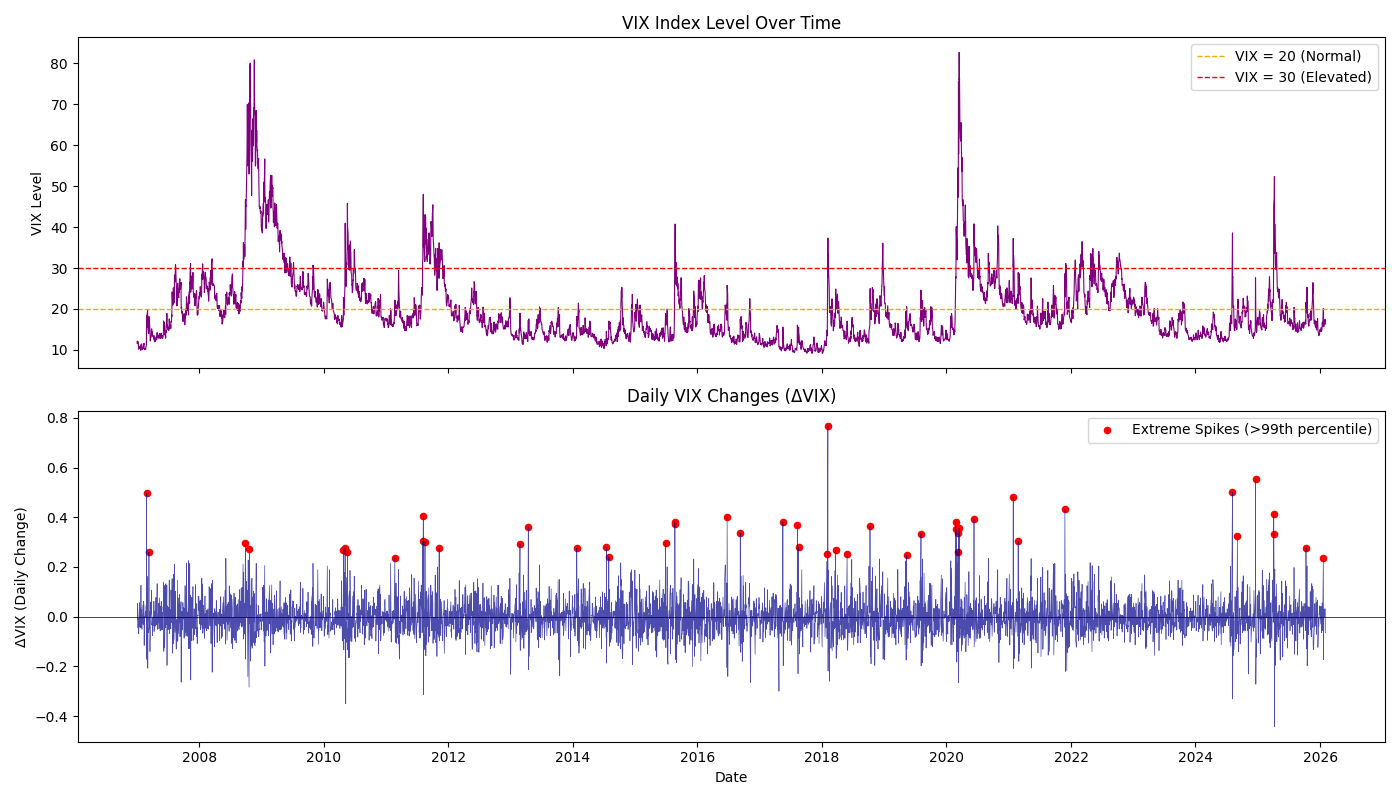

Figure 2: VIX level and daily changes showing volatility regime transitions.


In [10]:
# Figure 2: VIX Changes Over Time
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot VIX level
axes[0].plot(VIX["Close"], color='purple', linewidth=0.8)
axes[0].set_ylabel('VIX Level')
axes[0].set_title('VIX Index Level Over Time')
axes[0].axhline(y=20, color='orange', linestyle='--', linewidth=1, label='VIX = 20 (Normal)')
axes[0].axhline(y=30, color='red', linestyle='--', linewidth=1, label='VIX = 30 (Elevated)')
axes[0].legend()

# Plot VIX change (ΔVIX)
axes[1].plot(VIX_log_returns.index, VIX_log_returns['Close'], color='darkblue', alpha=0.7, linewidth=0.5)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_ylabel('ΔVIX (Daily Change)')
axes[1].set_title('Daily VIX Changes (ΔVIX)')
axes[1].set_xlabel('Date')

# Highlight extreme VIX spikes
vix_spikes = VIX_log_returns['Close'] > VIX_log_returns['Close'].quantile(0.99)
axes[1].scatter(VIX_log_returns.index[vix_spikes], VIX_log_returns.loc[vix_spikes, 'Close'],
                color='red', s=20, label='Extreme Spikes (>99th percentile)')
axes[1].legend()

plt.tight_layout()
plt.savefig('vix_changes_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure 2: VIX level and daily changes showing volatility regime transitions.")

In [168]:
pip install backtrader


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Step 2: Modeling VIX Regimes

# Here we define the function of discretize vix changes 

# Discretize ΔVIX into states using quantiles
def discretize_vix_changes(vix_changes, n_states=3):
    """
    Discretize VIX changes into n_states using quantile-based thresholds.
    """
    if n_states == 2:
        threshold = vix_changes.quantile(0.5)
        states = pd.Series(np.where(vix_changes <= threshold, 0, 1), index=vix_changes.index)
        state_labels = {0: 'Low Vol', 1: 'High Vol'}
    elif n_states == 3:
        q33 = vix_changes.quantile(0.33)
        q67 = vix_changes.quantile(0.67)
        conditions = [
            vix_changes <= q33,
            (vix_changes > q33) & (vix_changes <= q67),
            vix_changes > q67
        ]
        states = pd.Series(np.select(conditions, [0, 1, 2]), index=vix_changes.index)
        state_labels = {0: 'Low Vol', 1: 'Medium Vol', 2: 'High Vol'}

    return states, state_labels

In [12]:
# Create 2-state and 3-state discretizations
states_2, labels_2 = discretize_vix_changes(VIX_log_returns['Close'], n_states=2)
states_3, labels_3 = discretize_vix_changes(VIX_log_returns['Close'], n_states=3)

print("=== Discretization Results ===")
print(f"\n2-State Distribution:\n{states_2.value_counts().sort_index()}")
print(f"\n3-State Distribution:\n{states_3.value_counts().sort_index()}")



=== Discretization Results ===

2-State Distribution:
0    2400
1    2400
Name: count, dtype: int64

3-State Distribution:
0    1584
1    1632
2    1584
Name: count, dtype: int64


In [13]:
# Estimate Transition Matrix
def estimate_transition_matrix(states, n_states):
    """
    Estimate transition matrix from state sequence.
    """
    transition_counts = np.zeros((n_states, n_states))

    for i in range(len(states) - 1):
        current_state = int(states.iloc[i])
        next_state = int(states.iloc[i + 1])
        transition_counts[current_state, next_state] += 1

    # Normalize to get probabilities
    row_sums = transition_counts.sum(axis=1, keepdims=True)
    transition_matrix = transition_counts / row_sums

    return transition_matrix, transition_counts

In [14]:
# 2-State Markov Chain
trans_matrix_2, counts_2 = estimate_transition_matrix(states_2, 2)
print("\n=== 2-State Transition Matrix ===")
trans_df_2 = pd.DataFrame(trans_matrix_2,
                          index=['From Low Vol', 'From High Vol'],
                          columns=['To Low Vol', 'To High Vol'])
print(trans_df_2.round(4))

# 3-State Markov Chain
trans_matrix_3, counts_3 = estimate_transition_matrix(states_3, 3)
print("\n=== 3-State Transition Matrix ===")
trans_df_3 = pd.DataFrame(trans_matrix_3,
                          index=['From Low', 'From Medium', 'From High'],
                          columns=['To Low', 'To Medium', 'To High'])
print(trans_df_3.round(4))


=== 2-State Transition Matrix ===
               To Low Vol  To High Vol
From Low Vol       0.4756       0.5244
From High Vol      0.5242       0.4758

=== 3-State Transition Matrix ===
             To Low  To Medium  To High
From Low     0.3241     0.3392   0.3367
From Medium  0.2721     0.3799   0.3480
From High    0.3952     0.2999   0.3049


In [15]:
# Compute Stationary Distribution
def compute_stationary_distribution(trans_matrix):
    """
    Compute stationary distribution of Markov chain.
    """
    eigenvalues, eigenvectors = np.linalg.eig(trans_matrix.T)

    # Find eigenvector corresponding to eigenvalue 1
    idx = np.argmin(np.abs(eigenvalues - 1))
    stationary = np.real(eigenvectors[:, idx])
    stationary = stationary / stationary.sum()

    return stationary

stat_dist_2 = compute_stationary_distribution(trans_matrix_2)
stat_dist_3 = compute_stationary_distribution(trans_matrix_3)

print("\n=== Stationary Distributions ===")
print(f"2-State: Low Vol = {stat_dist_2[0]:.4f}, High Vol = {stat_dist_2[1]:.4f}")
print(f"3-State: Low = {stat_dist_3[0]:.4f}, Medium = {stat_dist_3[1]:.4f}, High = {stat_dist_3[2]:.4f}")


=== Stationary Distributions ===
2-State: Low Vol = 0.4999, High Vol = 0.5001
3-State: Low = 0.3299, Medium = 0.3401, High = 0.3301


In [16]:
VIX_log_returns.dropna()

,Close
Date,
2007-01-04 00:00:00-05:00,-0.045018
2007-01-05 00:00:00-05:00,0.053290
2007-01-08 00:00:00-05:00,-0.011599
2007-01-09 00:00:00-05:00,-0.007528
2007-01-10 00:00:00-05:00,-0.037643
...,...
2026-01-27 00:00:00-05:00,0.012308
2026-01-28 00:00:00-05:00,0.000000
2026-01-29 00:00:00-05:00,0.031902


In [17]:
# Prepare data for HMM
VIX_log_returns['Close'].dropna()
vix_data = VIX_log_returns['Close'].values.reshape(-1, 1)


# Fit 2-State Gaussian HMM
np.random.seed(42)
hmm_2 = hmm.GaussianHMM(n_components=2, covariance_type='full', n_iter=1000, random_state=42)
hmm_2.fit(vix_data)

# Extract parameters
print("\n=== 2-State HMM Parameters ===")
print(f"Means: {hmm_2.means_.flatten()}")
print(f"Variances: {hmm_2.covars_.flatten()}")
print(f"Transition Matrix:\n{hmm_2.transmat_}")
print(f"Initial State Probabilities: {hmm_2.startprob_}")
print(f"Log-Likelihood: {hmm_2.score(vix_data):.2f}")

# Get most likely state sequence (Viterbi)
hidden_states_2 = hmm_2.predict(vix_data)

# Get smoothed probabilities
state_probs_2 = hmm_2.predict_proba(vix_data)

# Fit 3-State Gaussian HMM
np.random.seed(42)
hmm_3 = hmm.GaussianHMM(n_components=3, covariance_type='full', n_iter=1000, random_state=42)
hmm_3.fit(vix_data)

print("\n=== 3-State HMM Parameters ===")
print(f"Means: {hmm_3.means_.flatten()}")
print(f"Transition Matrix:\n{hmm_3.transmat_}")
print(f"Log-Likelihood: {hmm_3.score(vix_data):.2f}")

# Get most likely state sequence
hidden_states_3 = hmm_3.predict(vix_data)
state_probs_3 = hmm_3.predict_proba(vix_data)



=== 2-State HMM Parameters ===
Means: [-0.00551397  0.01852905]
Variances: [0.00256266 0.01688783]
Transition Matrix:
[[0.95058197 0.04941803]
 [0.16352067 0.83647933]]
Initial State Probabilities: [1.00000000e+00 2.17230149e-22]
Log-Likelihood: 6031.22

=== 3-State HMM Parameters ===
Means: [-0.06000373  0.05930807 -0.00362789]
Transition Matrix:
[[2.24973439e-01 4.64901170e-01 3.10125390e-01]
 [5.58274516e-01 4.41634044e-01 9.14398020e-05]
 [1.55809100e-08 5.16587105e-02 9.48341274e-01]]
Log-Likelihood: 6095.53


In [18]:
# Sort states by mean (for consistent interpretation)
def sort_hmm_states(hmm_model, states, state_probs):
    """
    Reorder HMM states so that state 0 has lowest mean, etc.
    """
    means = hmm_model.means_.flatten()
    order = np.argsort(means)

    # Create mapping
    new_states = np.zeros_like(states)
    new_probs = np.zeros_like(state_probs)

    for new_idx, old_idx in enumerate(order):
        new_states[states == old_idx] = new_idx
        new_probs[:, new_idx] = state_probs[:, old_idx]

    return new_states, new_probs, order

hidden_states_2_sorted, state_probs_2_sorted, order_2 = sort_hmm_states(hmm_2, hidden_states_2, state_probs_2)
hidden_states_3_sorted, state_probs_3_sorted, order_3 = sort_hmm_states(hmm_3, hidden_states_3, state_probs_3)

In [19]:
# Add to dataframe
VIX_log_returns['MC_State_2'] = states_2.values
VIX_log_returns['MC_State_3'] = states_3.values
VIX_log_returns['HMM_State_2'] = hidden_states_2_sorted
VIX_log_returns['HMM_State_3'] = hidden_states_3_sorted

print("\nState sequences added to log_returns DataFrame")
print(f"Columns: {VIX_log_returns.columns.tolist()}")




State sequences added to log_returns DataFrame
Columns: ['Close', 'MC_State_2', 'MC_State_3', 'HMM_State_2', 'HMM_State_3']


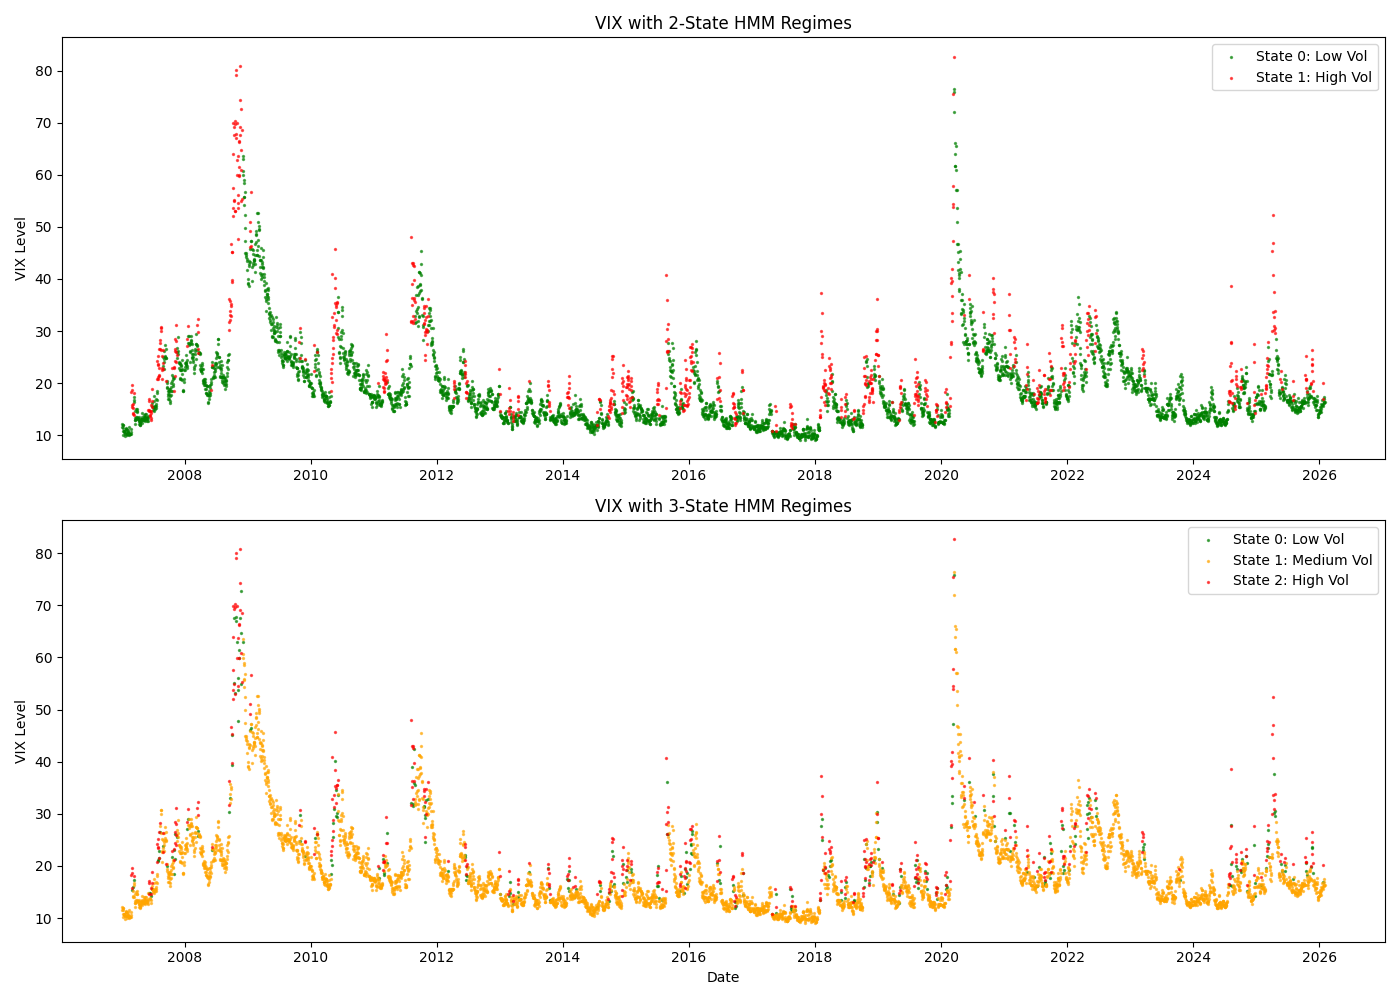

In [20]:
# Plot VIX with color-coded HMM states
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 2-State HMM
colors_2 = {0: 'green', 1: 'red'}
state_names_2 = {0: 'Low Vol', 1: 'High Vol'}

for state in [0, 1]:
    mask = VIX_log_returns['HMM_State_2'] == state
    axes[0].scatter(VIX_log_returns.index[mask], VIX_historical.loc[VIX_log_returns.index[mask], 'Close'],
                   c=colors_2[state], s=2, alpha=0.6,
                   label=f'State {state}: {state_names_2[state]}')

axes[0].set_ylabel('VIX Level')
axes[0].set_title('VIX with 2-State HMM Regimes')
axes[0].legend()

# 3-State HMM
colors_3 = {0: 'green', 1: 'orange', 2: 'red'}
state_names_3 = {0: 'Low Vol', 1: 'Medium Vol', 2: 'High Vol'}

for state in [0, 1, 2]:
    mask = VIX_log_returns['HMM_State_3'] == state
    axes[1].scatter(VIX_log_returns.index[mask], VIX_historical.loc[VIX_log_returns.index[mask], 'Close'],
                   c=colors_3[state], s=2, alpha=0.6,
                   label=f'State {state}: {state_names_3[state]}')

axes[1].set_ylabel('VIX Level')
axes[1].set_xlabel('Date')
axes[1].set_title('VIX with 3-State HMM Regimes')
axes[1].legend()

plt.tight_layout()
plt.show()


In [22]:
VIX_historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-06-02 00:00:00-04:00,21.320000,21.680000,21.299999,21.480000,0,0.0,0.0
2000-06-05 00:00:00-04:00,23.059999,23.290001,22.590000,22.709999,0,0.0,0.0
2000-06-06 00:00:00-04:00,23.200001,23.240000,22.719999,23.049999,0,0.0,0.0
2000-06-07 00:00:00-04:00,23.170000,23.400000,22.340000,22.480000,0,0.0,0.0
2000-06-08 00:00:00-04:00,23.360001,23.530001,22.770000,22.770000,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-01-27 00:00:00-05:00,16.020000,16.370001,15.740000,16.350000,0,0.0,0.0
2026-01-28 00:00:00-05:00,16.090000,17.180000,16.049999,16.350000,0,0.0,0.0
2026-01-29 00:00:00-05:00,16.040001,19.740000,16.020000,16.879999,0,0.0,0.0


# Vix futures strategy: 

In [120]:
pip install TA-lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [TA-lib]

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import talib as tb
import seaborn as sns
from datetime import date, timedelta, datetime
from dateutil import parser
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import export_text
from sklearn import tree, datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score, confusion_matrix
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')

To calculate the current level of contango we use the following formula: 

\begin{equation}
\mathrm{Ct}_{\mathrm{M}_{\mathrm{i}}, \mathrm{M}_{\mathrm{i}+1}}=\frac{\left(\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}+1}}-\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}}}\right) \cdot 100}{\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}}}}
\end{equation}

Where:

- $\mathrm{Ct}_{\mathrm{M}_{\mathrm{j}}, \mathrm{M}_{\mathrm{i}+1}}$ is % Contango between month $\mathrm{M}_{\mathrm{i}+1}$ and month $\mathrm{M}_{\mathrm{i}}$ VIX Futures.
- $\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}+1}}$ and FVIX $\mathrm{M}_{\mathrm{i}}$ are VIX future values at month $\mathrm{M}_{\mathrm{i}+1}$ and $\mathrm{M}_{\mathrm{i}}$ respectively.



In [22]:
# Dates Setup
start_date = date(2016, 3, 1)
end_date = date(2022, 4, 8)

In [23]:
# Get VIX Futures Term Structure Historical Data
vix_futures_csv = 'https://raw.githubusercontent.com/ayoubbensakhria/wqu690/master/data/vix_futures.csv'
df = pd.read_csv(vix_futures_csv, parse_dates=True)
# reverse df
df = df[::-1]
# set df index
df.index = pd.to_datetime(df['Date']).dt.date
# Drop unwanted columns for the current Experiment
columns_drop = ['Date', 'VXX', 'M1 Weight', 'M2 Weight', 'Weighted M1 M2', 'HV5', 'HV10', 'HV20', 'HV30', 'HV60', 'VVIX', 'VXX Bias', 'VRP', 'VIX GEX']
df.drop(columns_drop, axis=1, inplace=True)
# rename VIX3M
df.rename(columns={"VIX3M": "M3"}, inplace=True)
# Get data between start & end dates
mask = (df.index >= start_date) & (df.index< end_date)
df = df[mask]
# Compute Contango values
df['contango_m1'] = (df['M1'] - df['VIX'])*100/df['VIX']
df['contango_m2'] = (df['M2'] - df['M1'])*100/df['M1']
df['contango_m3'] = (df['M3'] - df['M2'])*100/df['M2']
df.head()

,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3
Date,,,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,1978.35,9.604520,4.639175,-0.098522
2016-03-02,17.09,19.30,20.25,19.92,1986.45,12.931539,4.922280,-1.629630
2016-03-03,16.70,18.35,19.50,19.49,1993.40,9.880240,6.267030,-0.051282
2016-03-04,16.86,18.95,20.00,19.63,1999.99,12.396204,5.540897,-1.850000
2016-03-07,17.35,18.60,19.80,19.90,2001.76,7.204611,6.451613,0.505051


In [24]:
ixic = yf.download(tickers='^IXIC', start=start_date, end=end_date, interval="1d")
ixic.rename(columns={"Close": "IXIC"}, inplace=True)
ixic.columns = ixic.columns.droplevel(1)
df = df.join(ixic)

[*********************100%***********************]  1 of 1 completed


In [25]:
df

,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3,IXIC,High,Low,Open,Volume
Date,,,,,,,,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,1978.3500,9.604520,4.639175,-0.098522,4689.600098,4689.600098,4581.750000,4596.009766,2080150000
2016-03-02,17.09,19.30,20.25,19.92,1986.4500,12.931539,4.922280,-1.629630,4703.419922,4703.580078,4665.930176,4683.799805,1912510000
2016-03-03,16.70,18.35,19.50,19.49,1993.4000,9.880240,6.267030,-0.051282,4707.419922,4707.720215,4674.459961,4698.379883,1936290000
2016-03-04,16.86,18.95,20.00,19.63,1999.9900,12.396204,5.540897,-1.850000,4717.020020,4746.649902,4687.939941,4715.759766,2171230000
2016-03-07,17.35,18.60,19.80,19.90,2001.7600,7.204611,6.451613,0.505051,4708.250000,4731.189941,4674.819824,4690.879883,2084390000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,19.63,22.50,24.40,24.21,4545.8599,14.620479,8.444444,-0.778689,14261.500000,14306.940430,14131.809570,14269.530273,5002790000
2022-04-04,18.57,21.00,23.21,23.03,4582.6401,13.085622,10.523810,-0.775528,14532.549805,14534.379883,14286.450195,14304.349609,4630100000
2022-04-05,21.03,22.85,24.55,24.90,4525.1201,8.654303,7.439825,1.425662,14204.169922,14500.290039,14169.120117,14490.259766,4727710000


In [26]:
df['vix_macd'], df['vix_signal'], df['vix_hist'] = tb.MACDFIX(df['VIX'])
df['spx_macd'], df['spx_signal'], df['spx_hist'] = tb.MACDFIX(df['SPX'])
df['ixic_macd'], df['ixic_signal'], df['ixic_hist'] = tb.MACDFIX(df['IXIC'])
df = df.dropna()
df.head()

,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3,IXIC,High,...,Volume,vix_macd,vix_signal,vix_hist,spx_macd,spx_signal,spx_hist,ixic_macd,ixic_signal,ixic_hist
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-18,13.35,13.83,16.22,16.51,2094.34,3.595506,17.281273,1.787916,4960.020020,4960.790039,...,1672260000,-0.796753,-0.883620,0.086867,20.304154,20.196193,0.107961,58.506234,57.023238,1.482997
2016-04-19,13.24,13.25,16.22,16.47,2100.80,0.075529,22.415094,1.541307,4940.330078,4968.669922,...,1824250000,-0.814510,-0.869798,0.055289,21.249709,20.406896,0.842813,57.491694,57.116929,0.374765
2016-04-20,13.28,16.45,17.90,16.60,2102.40,23.870482,8.814590,-7.262570,4948.129883,4969.319824,...,1781340000,-0.816307,-0.859100,0.042793,21.874093,20.700335,1.173758,56.632215,57.019986,-0.387771
2016-04-21,13.95,16.80,18.45,17.14,2091.48,20.430108,9.821429,-7.100271,4945.890137,4966.609863,...,1758190000,-0.758287,-0.838937,0.080650,21.299931,20.820254,0.479676,55.151357,56.646260,-1.494903
2016-04-22,13.22,16.20,18.00,16.64,2091.58,22.541604,11.111111,-7.555556,4906.229980,4921.660156,...,2018930000,-0.758888,-0.822928,0.064039,20.616372,20.779478,-0.163106,50.392068,55.395422,-5.003354


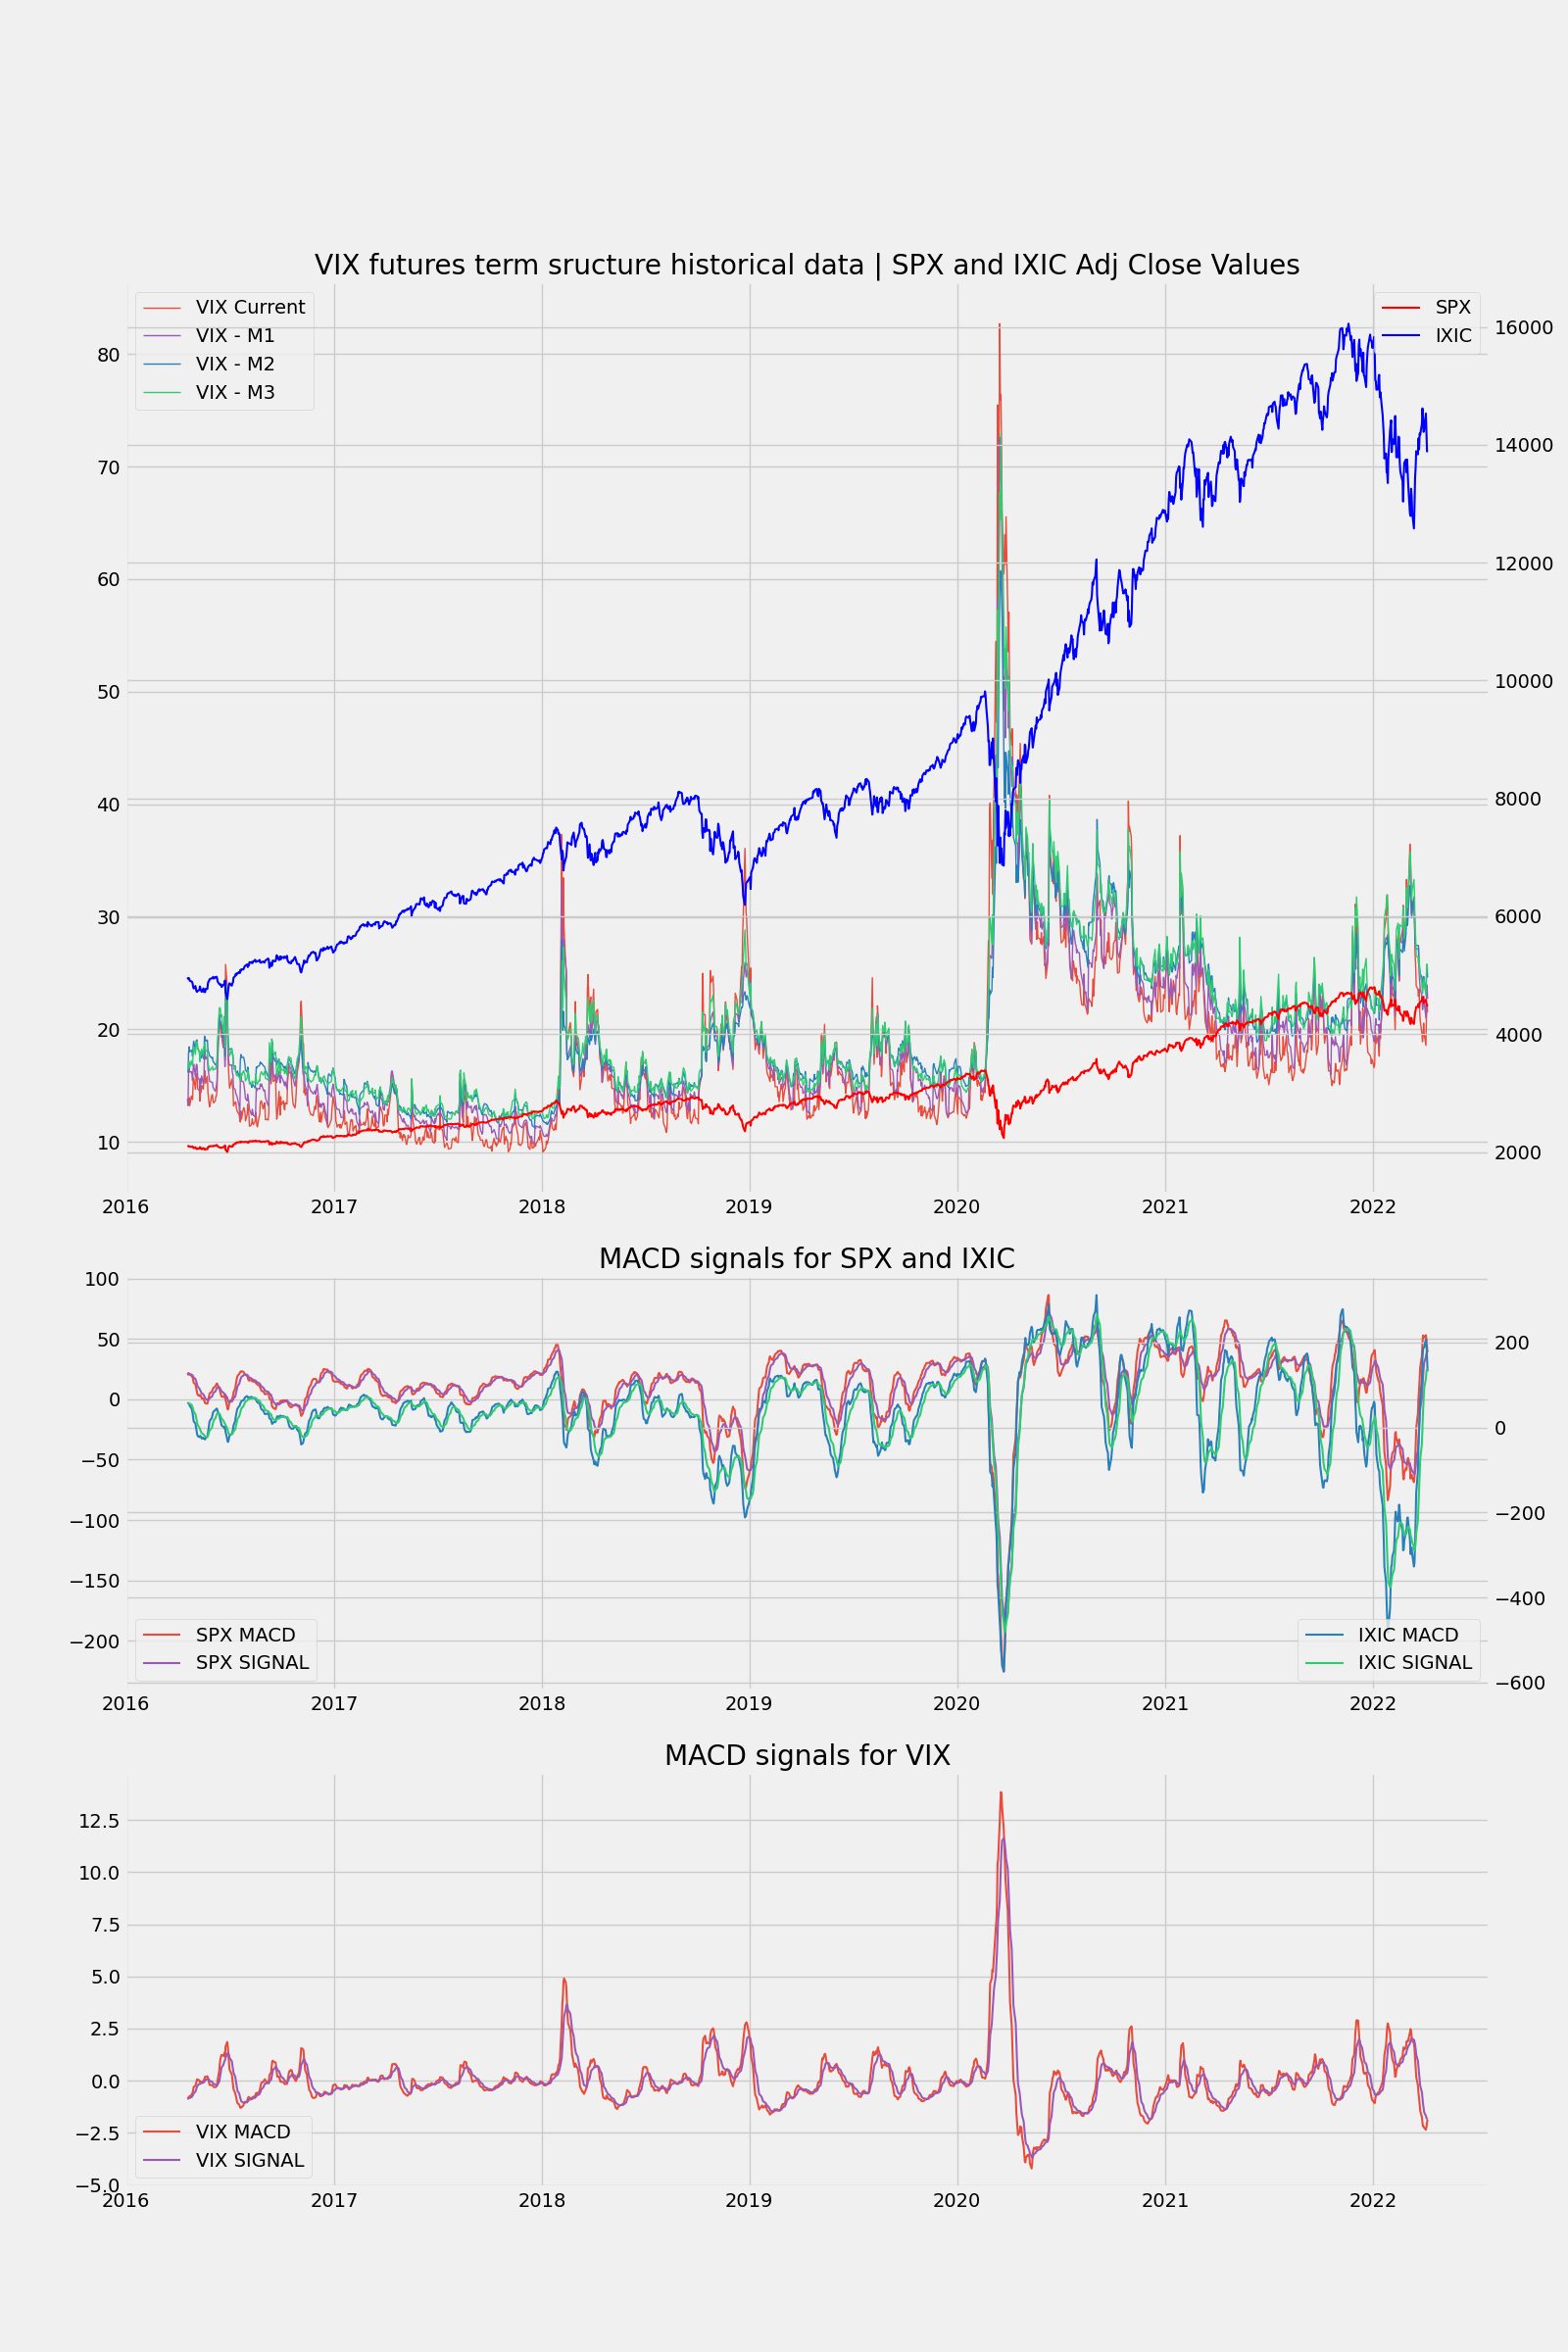

In [27]:
# Info: (x1, y1), (x2, y2)
# x1: number of rows, y1: number of columns 
# x2: row number, y2: column number
# documentation -> https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot2grid.html
# Axe VIX with M1, M2, M3 maturities
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((4, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(df['VIX'], color = '#E74C3C', linewidth = 1,  label = 'VIX Current')
vix_values.plot(df['M1'], color = '#9B59B6', linewidth = 1, label = 'VIX - M1')
vix_values.plot(df['M2'], color = '#2980B9', linewidth = 1, label = 'VIX - M2')
vix_values.plot(df['M3'], color = '#2ECC71', linewidth = 1,  label = 'VIX - M3')
plt.legend(loc = 'upper left')
# Axe prices: SPX and IXIC Close Prices
axe_prices = vix_values.twinx()
axe_prices.plot(df['SPX'], color = 'red', linewidth = 1.5, label = 'SPX')
axe_prices.plot(df['IXIC'], color = 'blue', linewidth = 1.5, label = 'IXIC')
# add titles to subplots
axe_prices.set_title('VIX futures term sructure historical data | SPX and IXIC Adj Close Values')
# set legend position
plt.legend(loc = 'upper right')
# Plot SPX and IXIC MACD
axe_spx_macd = plt.subplot2grid((4, 1), (2,0),  colspan = 1)
axe_spx_macd.plot(df['spx_macd'], color = '#E74C3C', linewidth = 1.5, label = 'SPX MACD')
axe_spx_macd.plot(df['spx_signal'], color = '#9B59B6', linewidth = 1.5, label = 'SPX SIGNAL')
plt.legend(loc = 'lower left')
axe_ixic_macd = axe_spx_macd.twinx()
axe_ixic_macd.plot(df['ixic_macd'], color = '#2980B9', linewidth = 1.5, label = 'IXIC MACD')
axe_ixic_macd.plot(df['ixic_signal'], color = '#2ECC71', linewidth = 1.5, label = 'IXIC SIGNAL')
axe_ixic_macd.set_title('MACD signals for SPX and IXIC')
plt.legend(loc = 'lower right')
# Plot VIX MACD
axe_vix_macd = plt.subplot2grid((4, 1), (3,0),  colspan = 1)
axe_vix_macd.plot(df['vix_macd'], color = '#E74C3C', linewidth = 1.5, label = 'VIX MACD')
axe_vix_macd.plot(df['vix_signal'], color = '#9B59B6', linewidth = 1.5, label = 'VIX SIGNAL')
axe_vix_macd.set_title('MACD signals for VIX')
plt.legend(loc = 'lower left')

# 5. Compute IXIC trading entry positions (Labels)

We compute IXIC entry positions on each point based on the next $l$ historical prices, determined risk:reward ratio, and our profit target.


Entry positions (signals) can have one of the following values: -1 (Sell), 1 (Buy), 0 (No Trade). These values will be used as target values to train our model.

To compute signal values from the next l prices we use the following formula:

\begin{equation}
\mathrm{E}_{\mathrm{t}, 1}=\operatorname{sgn}\left(\log \left(\left|\frac{\frac{\max _{\mathrm{t} \leq i \leq t+l} p_{i}-p_{t}}{p_{t}}}{\frac{\min _{t \leq i \leq t+l} p_{i}-p_{t}}{p_{t}}}\right|\right)\right)
\end{equation}

Where $\mathrm{E}_{\mathrm{t}, 1}$ is the trading signal at $t$ computed using the next $l$ values.

sgn is defined as follows:

\begin{equation}
\operatorname{sgn}: \mathbb{R} \rightarrow\{-1,0,1\}
\end{equation}

\begin{equation}
x \mapsto \operatorname{sgn}(x)=\left\{\begin{array}{cc}
-1 & \text { if } x \leq \mathrm{T} \text { and } \frac{\max _{\mathrm{t} \leq i \leq t+l} p_{i}-p_{t}}{p_{t}}<\mathrm{s} \\
1 & \text { if } x \geq \mathrm{T} \text { and } \frac{\min _{t \leq i \leq t+l} p_{i}-p_{t}}{p_{t}}>-\mathrm{s} \\
0 & \text { Otherwise }
\end{array}\right.
\end{equation}
- $\max _{t \leq i \leq t+l} p_{i}:$ the maximum price value of the vector containing the next $l$ historical prices including the current price.
- $\min _{t \leq i \leq t+l} p_{i}:$ the minimum price value of the vector containing the next $l$ historical prices including the current price.
- $T$ : is the Log of the targeted returns (Max/Min) ratio.
- $p_{t}$ : is the price at time $\mathrm{t}$ (the current price).
- $\mathrm{s}$ is the rolling Log returns standard deviation: $s=\sqrt{\frac{1}{l-t} \sum_{i=t}^{l}\left(x_{i}-\bar{x}\right)^{2}}$

In [28]:
# Standard Deviation 
df['Change'] = (df['IXIC']-df['IXIC'].shift(-1))/df['IXIC'].shift(-1)
# compute the risk (std) and the target return
risk = df['Change'].std(skipna=True)
df.drop('Change', axis = 1, inplace=True)
# Define reward/risk coeff
reward_risk_coeff = 1.5

In [29]:
def sign (df, lags):  #<- lags = historical prices ahead of the current position
  # calculte rolling min and max prices (after the possible entrypoints)
  next_highest_price = df['IXIC'].rolling(lags).max().shift(-lags)
  next_lowest_price = df['IXIC'].rolling(lags).min().shift(-lags)
  # Filter entrypoints before building the model
  df['rolling_max_return'] = ((next_highest_price - df['IXIC']) / df['IXIC'])
  df['rolling_min_return'] = ((next_lowest_price - df['IXIC']) / df['IXIC'])
  #Compute E(t,l) = df['ep']
  df['ep'] = np.log(abs(df['rolling_max_return']/df['rolling_min_return']))
  # drop the last (lags) rows
  df = df[lags:]
  # generate signals for the training dataset
  # signal is +1 if the max price is above the target rate and the min price is above the risk 
  df['tsignal'] = df.apply(
      lambda row: 1 
      if (
          row['ep'] > math.log(reward_risk_coeff) 
          and row['rolling_min_return'] > -risk
          ) 
      else 0, axis =1)
  
  df['atsignal'] = df.apply(
      lambda row: -1 
      if (
          row['ep'] <= -math.log(reward_risk_coeff) 
          and row['rolling_max_return'] < risk
          ) 
      else 0, axis =1)
  
  # Merge sell signals and drop atsignals
  df['tsignal'].loc[df.tsignal==0] = df.loc[df.tsignal==0]['atsignal']
  # Drop unnecessary features
  df.drop(['atsignal', 'rolling_max_return', 'rolling_min_return', 'ep'] , axis=1, inplace=True)
  # drop nans after replacing infinity
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.dropna(inplace=True)
  return df
# lags value here l = 7, profit/loss = 2
df = sign(df, 7)

In [30]:
def plot_signals(df, title, ylabel):
  # Initialize the plot figure
  fig = plt.figure(figsize=(32,16))

  partddf = df[-200:]
  ## Add a subplot and label for y-axis
  axe_predictions = fig.add_subplot(111,ylabel=ylabel)

  ## Plot the closing price
  partddf['IXIC'].plot(ax=axe_predictions, color='#2ECC71', lw=5.)

  # Plot the buy signals
  axe_predictions.plot(partddf.loc[partddf.tsignal == 1.0].index, 
          partddf.IXIC[partddf.tsignal == 1.0],
          '^', markersize=10, color='b')

  # Plot the sell signals
  axe_predictions.plot(partddf.loc[df.tsignal == -1.0].index, 
          partddf.IXIC[df.tsignal == -1.0],
          'v', markersize=10, color='r')
  # Display plt
  axe_predictions.set_title(title)
  plt.show()

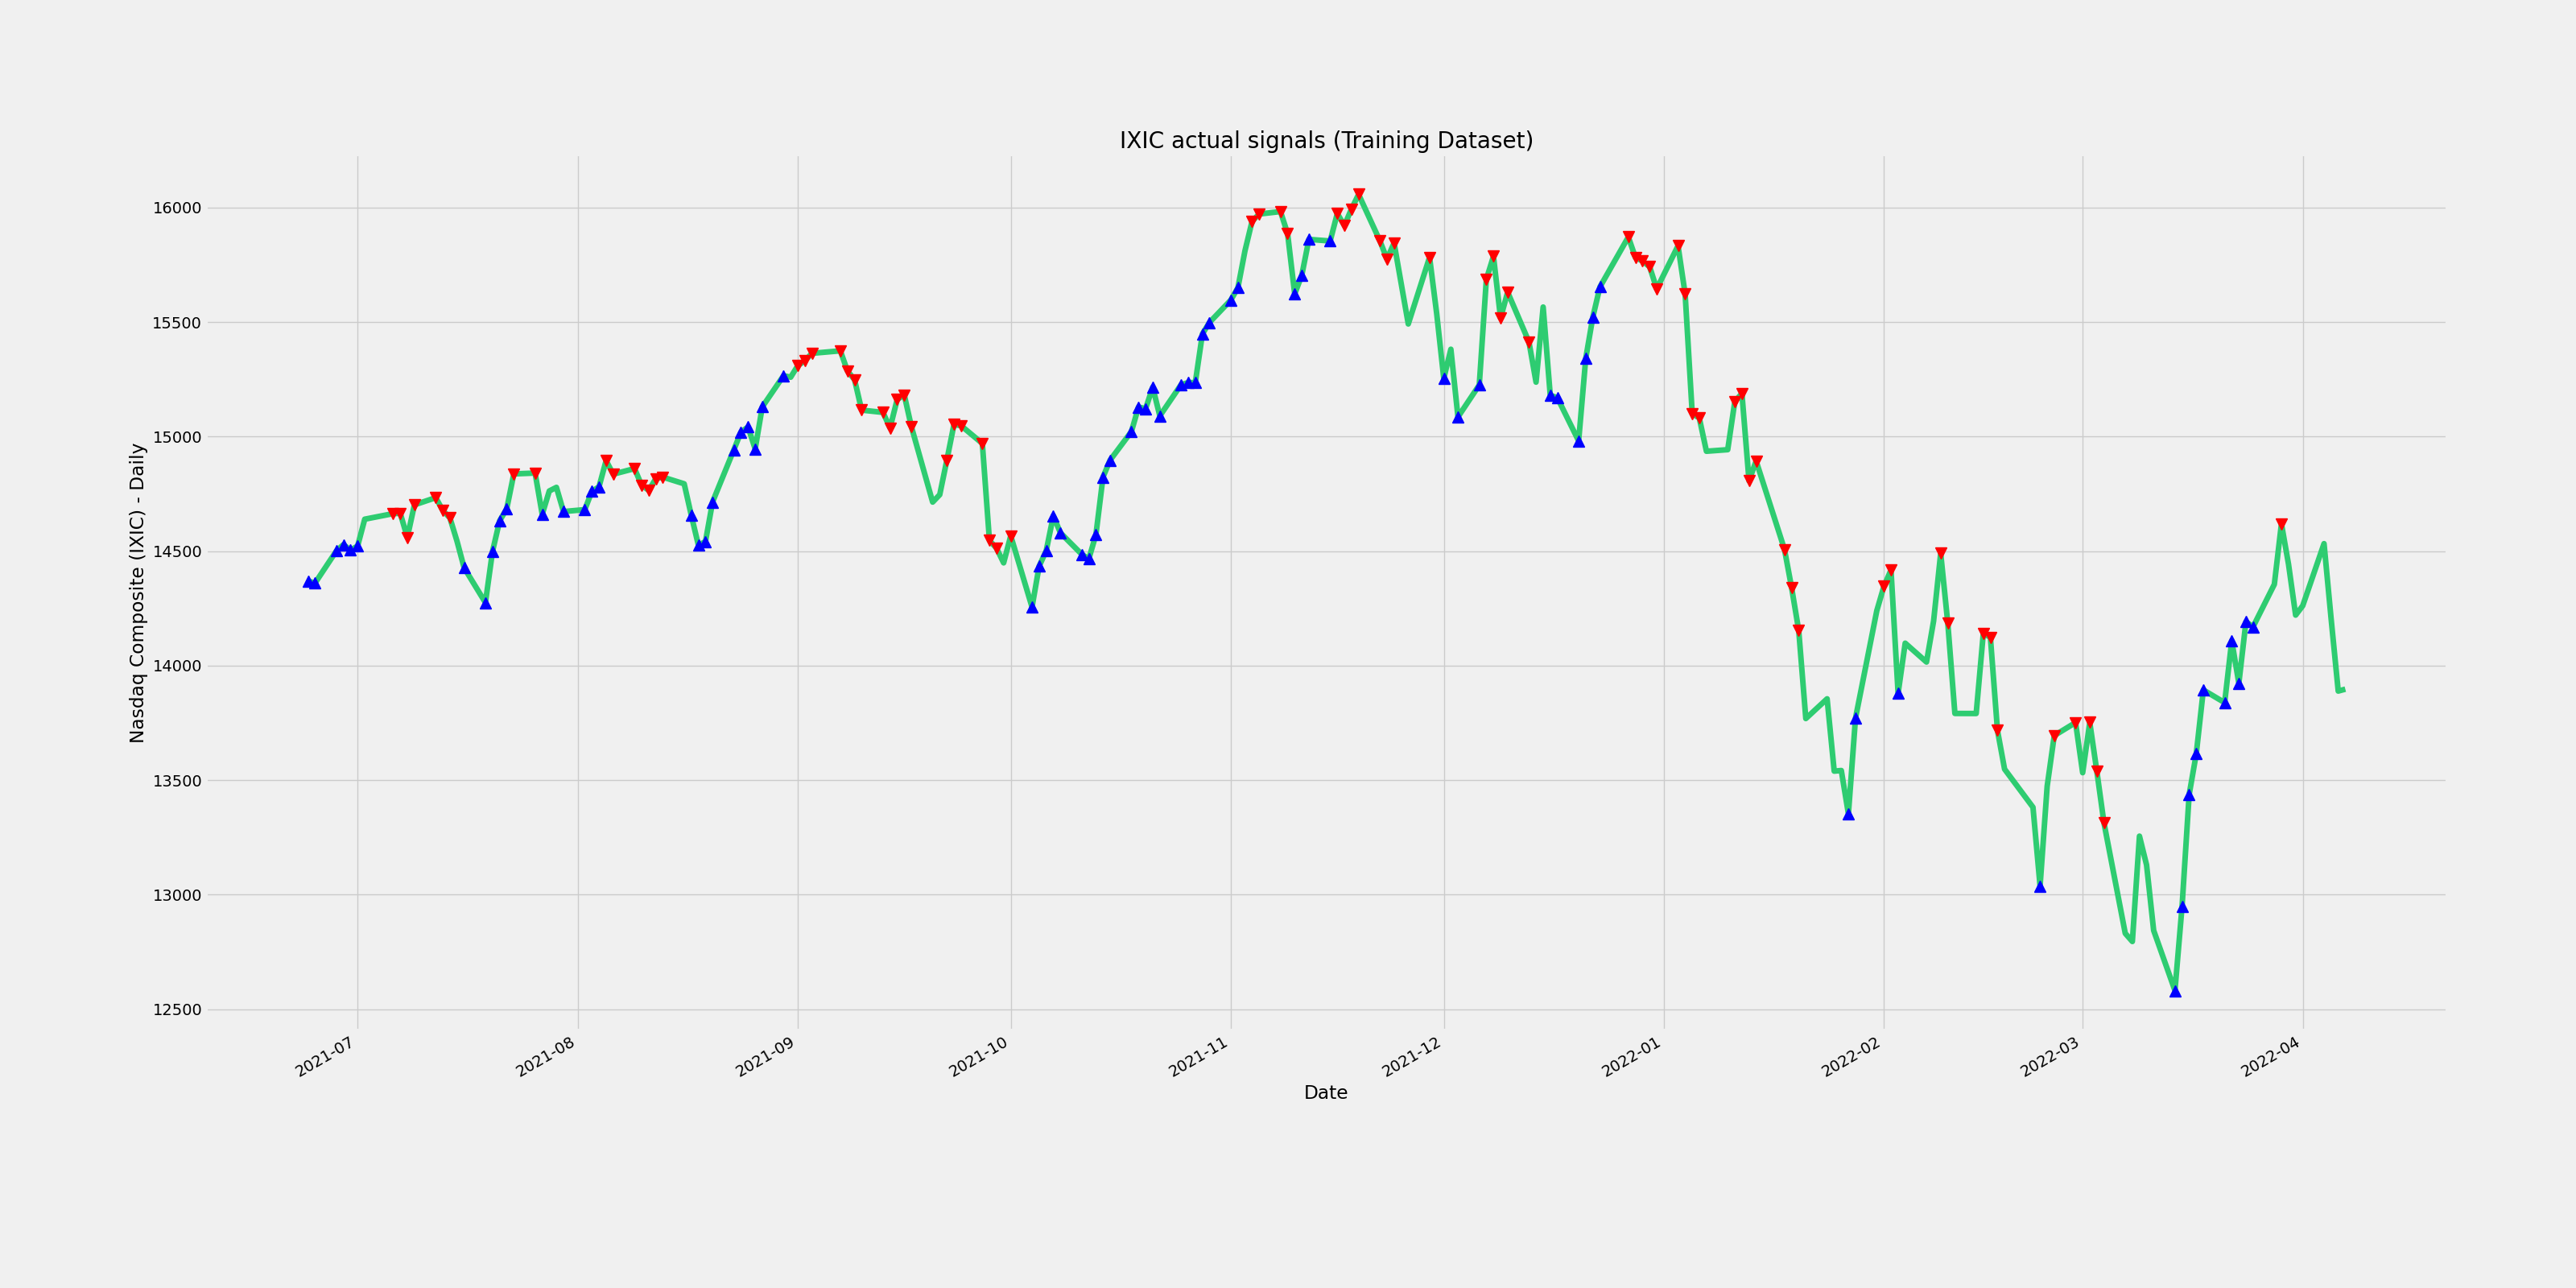

In [31]:
ylabel = 'Nasdaq Composite (IXIC) - Daily'
title = 'IXIC actual signals (Training Dataset)'
plot_signals(df, title, ylabel)

In [15]:
# Specify features
feature_names = list(df.columns)
non_features = ['tsignal', 'IXIC', 'VIX', 'SPX', 'M1', 'M2', 'M3', 'ixic_hist', 'spx_hist', 'vix_hist'] 
for nf in non_features:
  feature_names.remove(nf)
print(feature_names)

['contango_m1', 'contango_m2', 'contango_m3', 'High', 'Low', 'Open', 'Volume', 'vix_macd', 'vix_signal', 'spx_macd', 'spx_signal', 'ixic_macd', 'ixic_signal']


In [16]:
# train the RFC model
X = df[feature_names]
y = df['tsignal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

rfc = RandomForestClassifier(random_state=100)

rfc = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('Model accuracy', accuracy_score(y_test, y_pred, normalize=True))
print ('Cross Val score', np.mean(cross_val_score(rfc, X_train, y_train, cv=10)))
print(report)

Model accuracy 0.7766666666666666
Cross Val score 0.733095238095238
              precision    recall  f1-score   support

          -1       0.75      0.77      0.76        82
           0       0.41      0.32      0.36        38
           1       0.84      0.88      0.86       180

    accuracy                           0.78       300
   macro avg       0.67      0.65      0.66       300
weighted avg       0.76      0.78      0.77       300



In [38]:
"""
param_dict = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 10),
    "min_samples_split": range(1, 10),
    "min_samples_leaf": range(1, 10)
}

grid = GridSearchCV(rfc, 
                    param_grid=param_dict,
                    cv = 3,
                    verbose = 1,
                    n_jobs = -1,
                    return_train_score=True)

grid.fit(X_train, y_train)
grid.best_estimator_
"""

'\nparam_dict = {\n    "criterion": [\'gini\', \'entropy\'],\n    "max_depth": range(1, 10),\n    "min_samples_split": range(1, 10),\n    "min_samples_leaf": range(1, 10)\n}\n\ngrid = GridSearchCV(rfc, \n                    param_grid=param_dict,\n                    cv = 3,\n                    verbose = 1,\n                    n_jobs = -1,\n                    return_train_score=True)\n\ngrid.fit(X_train, y_train)\ngrid.best_estimator_\n'

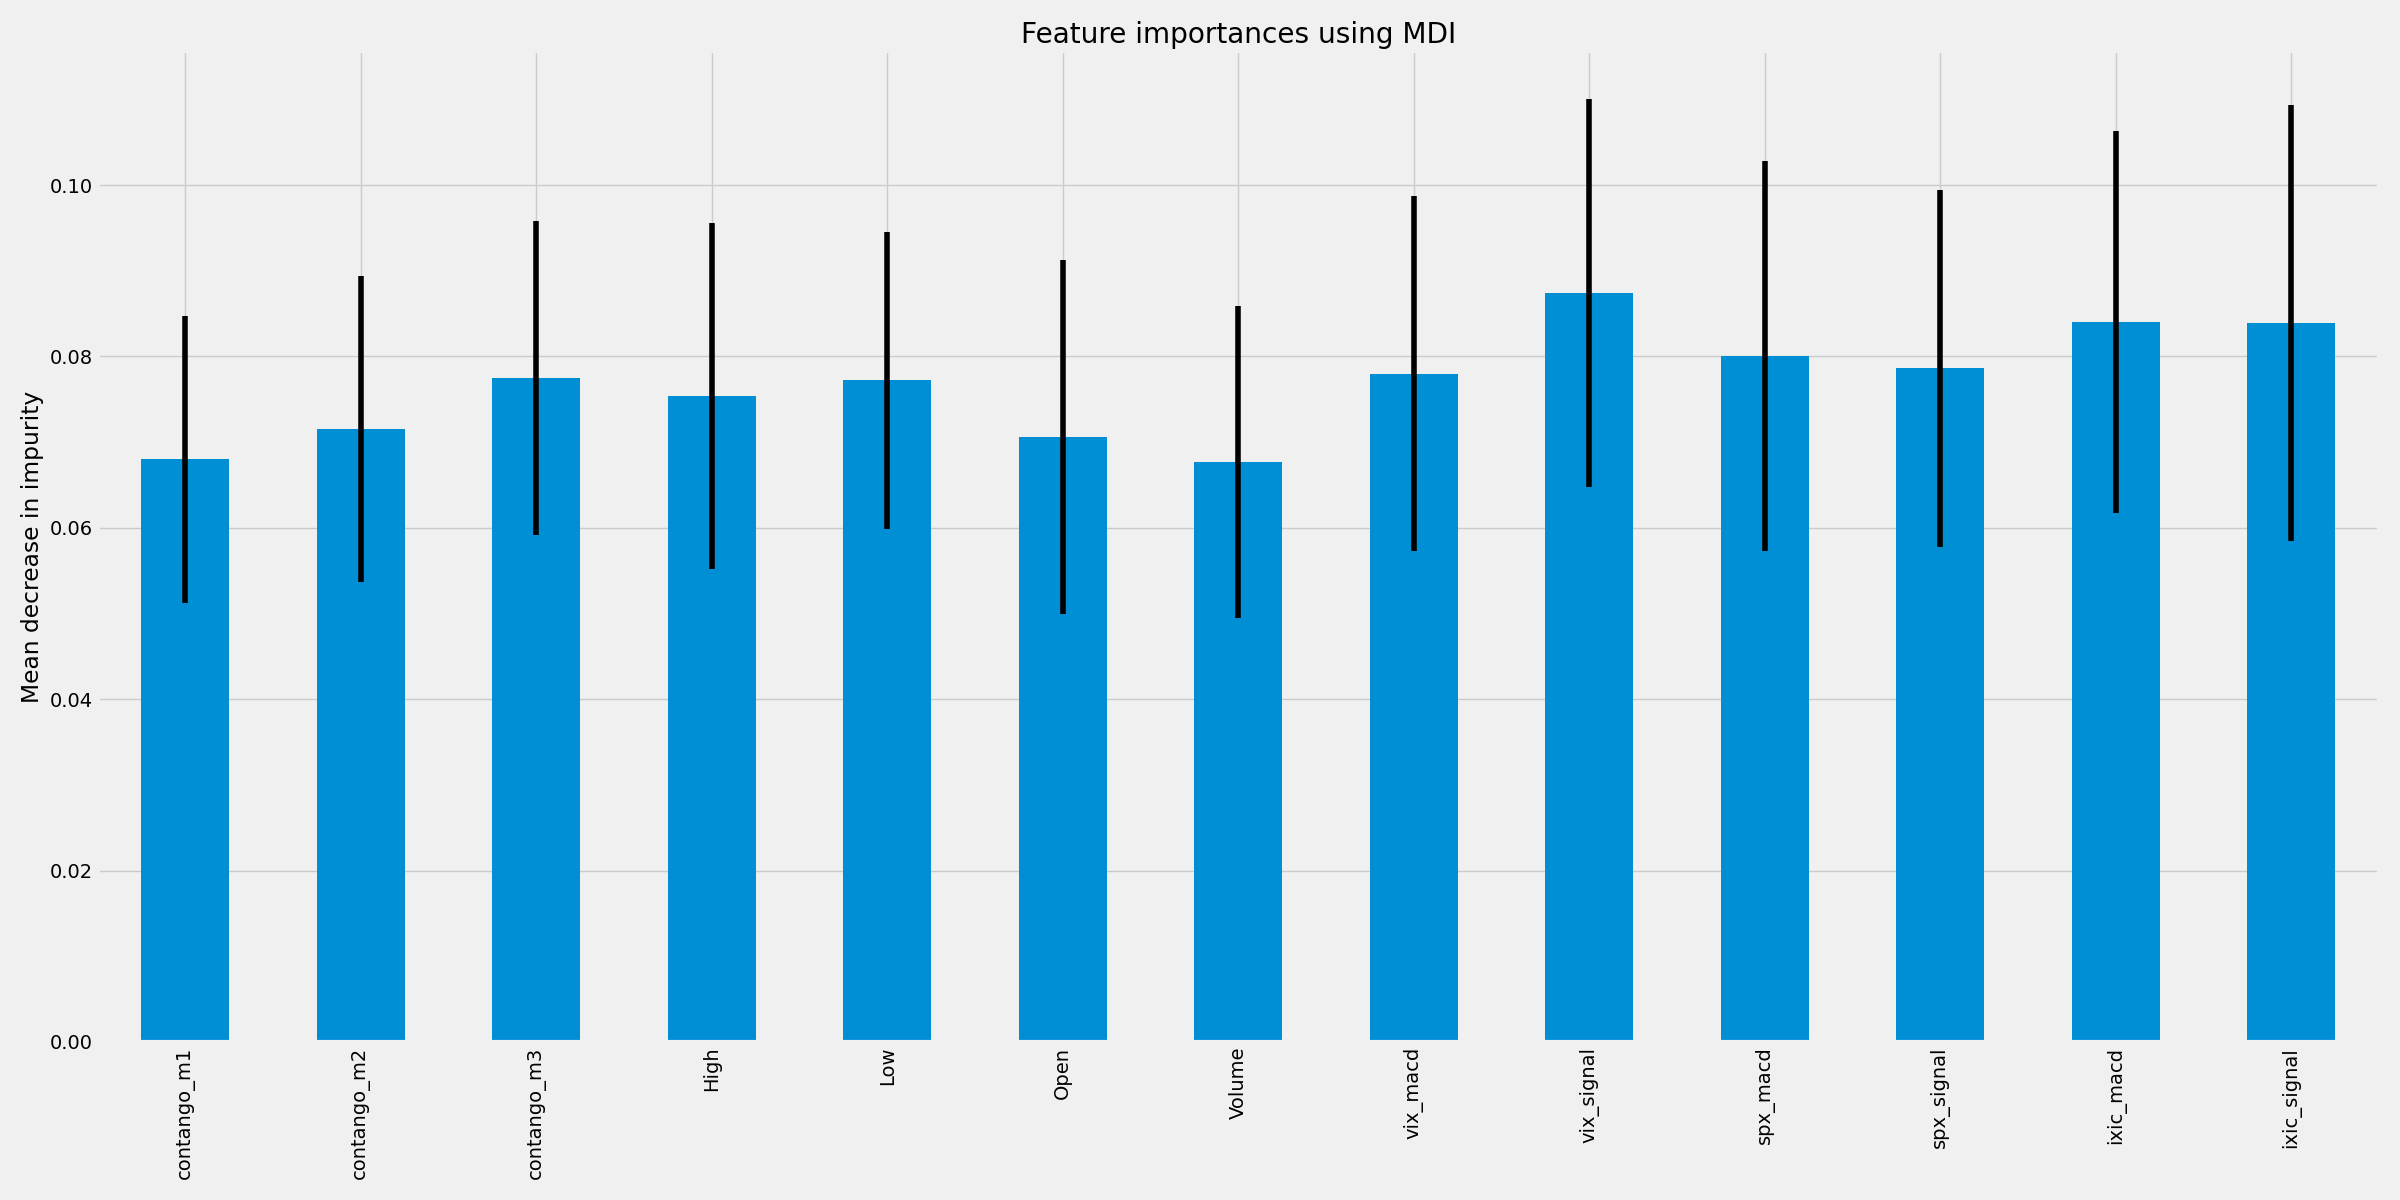

In [17]:
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [18]:
ddf = df.drop(non_features, axis=1)
ddf['predicted_signal'] = rfc.predict(ddf) 
ddf['IXIC'] = df['IXIC']
# reduce data (last 100 days)
display_days = 100
short_ddf = ddf[-display_days:]

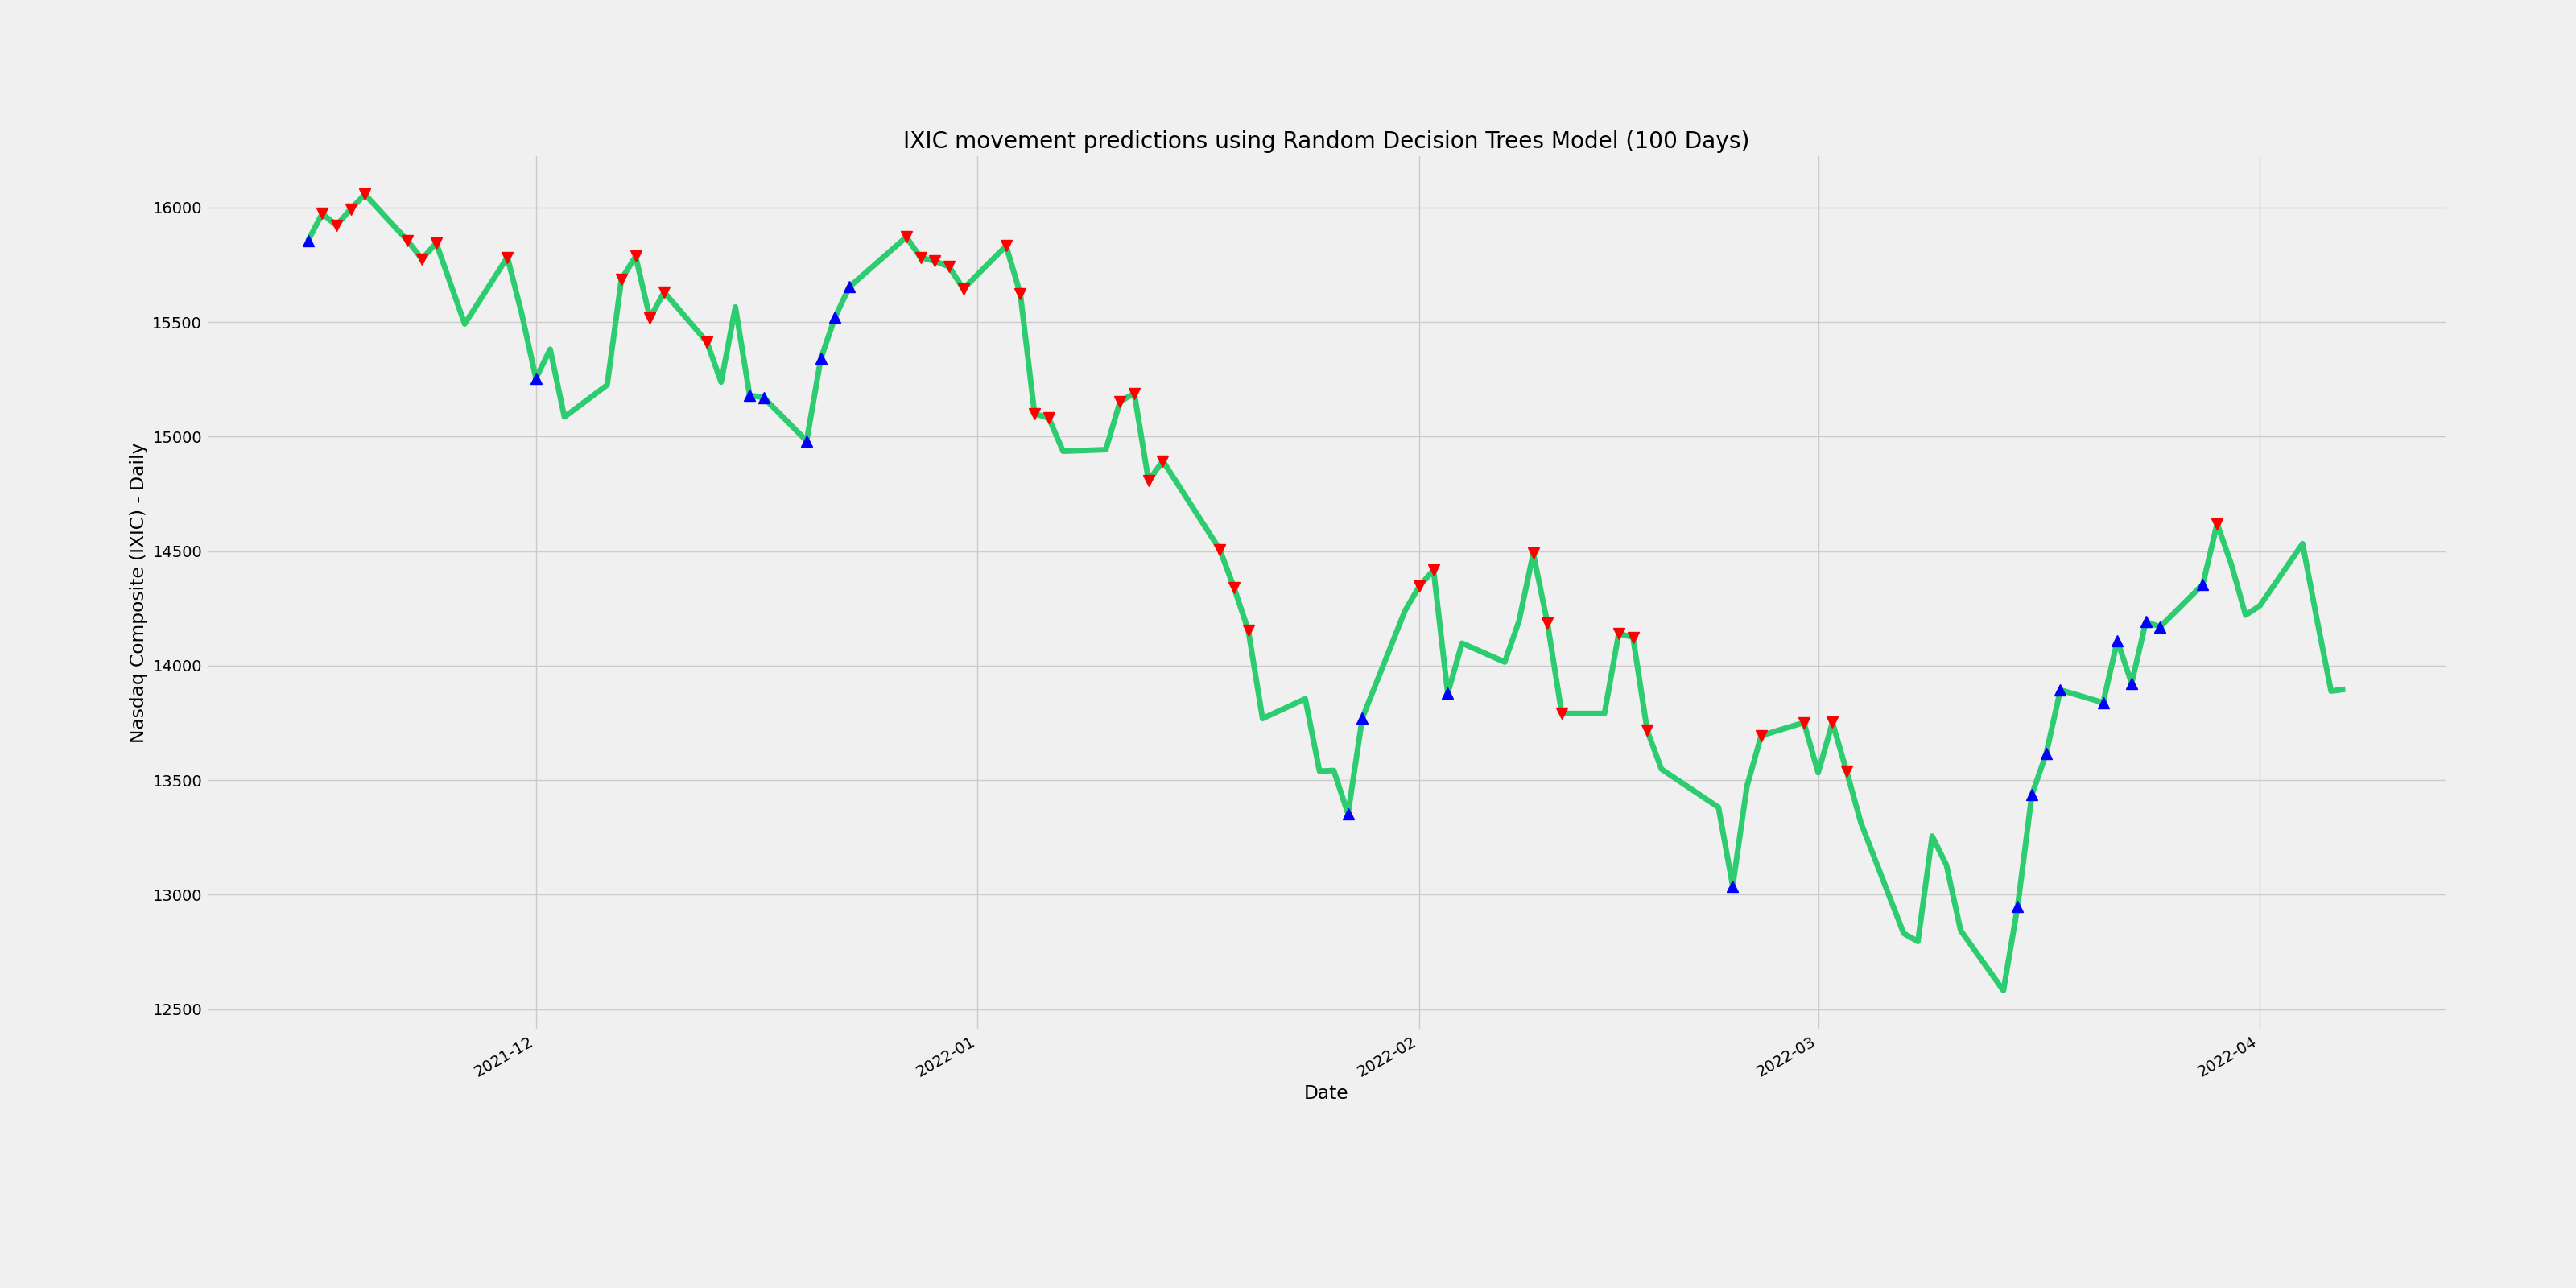

In [19]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
axe_predictions = fig.add_subplot(111,ylabel='Nasdaq Composite (IXIC) - Daily')

## Plot the closing price
short_ddf['IXIC'].plot(ax=axe_predictions, color='#2ECC71', lw=5.)

# Plot the buy signals
axe_predictions.plot(short_ddf.loc[short_ddf.predicted_signal == 1.0].index, 
         short_ddf.IXIC[ddf.predicted_signal == 1.0],
         '^', markersize=10, color='b')

# Plot the sell signals
axe_predictions.plot(short_ddf.loc[short_ddf.predicted_signal == -1.0].index, 
         short_ddf.IXIC[ddf.predicted_signal == -1.0],
         'v', markersize=10, color='r')
# Display plt
axe_predictions.set_title('IXIC movement predictions using Random Decision Trees Model ({last_days} Days)'.format(last_days=display_days))
plt.show()

In [20]:
signalDf = pd.DataFrame({'actual_signal':df['tsignal'] , 'predicted_signal':ddf['predicted_signal'], 'contango_m1': df['contango_m1']})
# take only test Data
contango = signalDf.loc[signalDf['contango_m1']>0]
backwardation = signalDf.loc[signalDf['contango_m1']<0]
print('Total signals: ', len(signalDf))
print('Contango Count:', len(contango))
print('Backwardation Count:', len(backwardation))
print('Accuracy in Contango (M1)', len(contango.loc[contango['predicted_signal'] == contango['actual_signal']])/len(contango))
print('Accuracy in Backwardation (M1)', len(backwardation.loc[backwardation['predicted_signal'] == backwardation['actual_signal']])/len(backwardation))

Total signals:  1499
Contango Count: 1189
Backwardation Count: 306
Accuracy in Contango (M1) 0.9571068124474348
Accuracy in Backwardation (M1) 0.9477124183006536


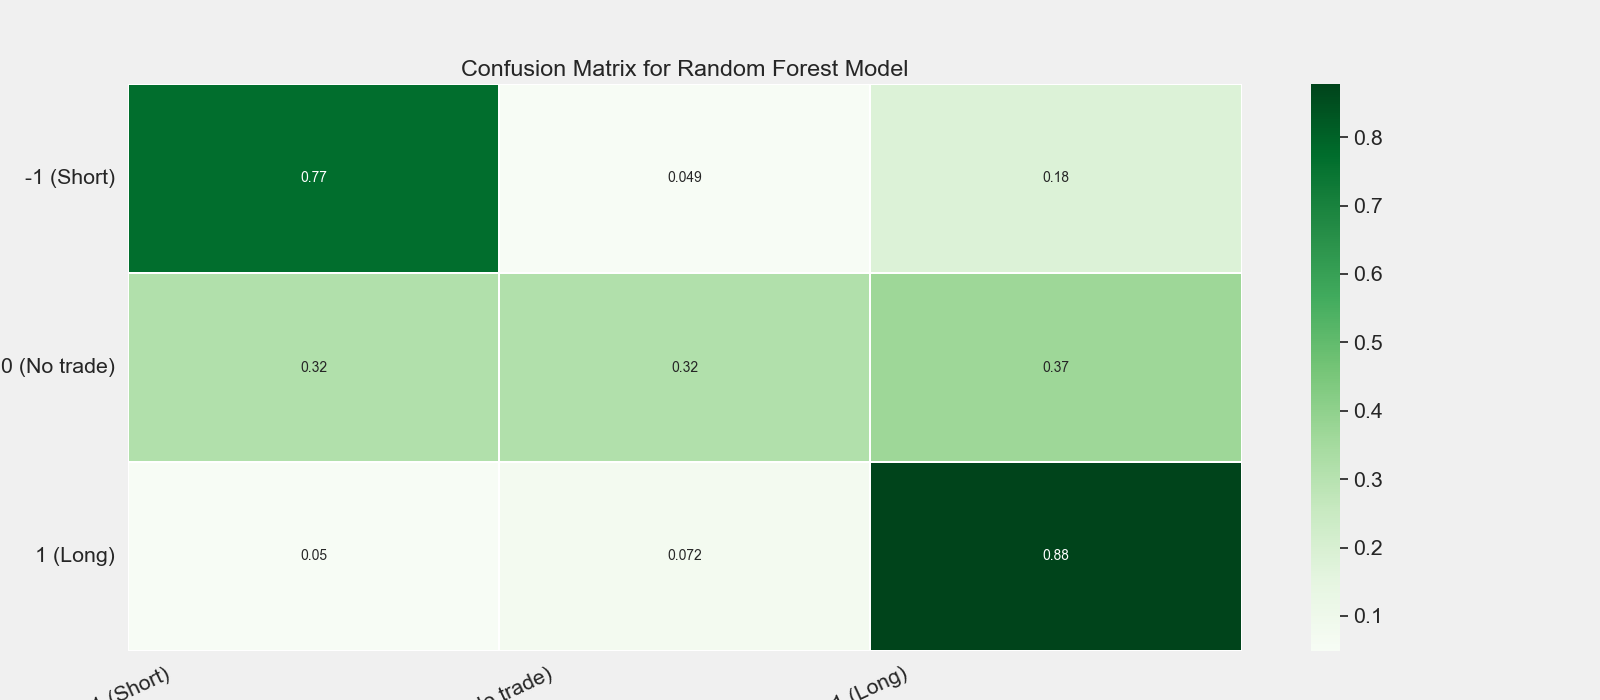

In [21]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['-1 (Short)', '0 (No trade)', '1 (Long)']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [24]:
prices

Price,high,low,open,volume
Ticker,^IXIC,^IXIC,^IXIC,^IXIC
Date,,,,
2016-03-01,4689.600098,4581.750000,4596.009766,2080150000
2016-03-02,4703.580078,4665.930176,4683.799805,1912510000
2016-03-03,4707.720215,4674.459961,4698.379883,1936290000
2016-03-04,4746.649902,4687.939941,4715.759766,2171230000
2016-03-07,4731.189941,4674.819824,4690.879883,2084390000
...,...,...,...,...
2022-04-01,14306.940430,14131.809570,14269.530273,5002790000
2022-04-04,14534.379883,14286.450195,14304.349609,4630100000


In [23]:
%matplotlib inline
import backtrader as bt
import pyfolio as pf
from backtrader.feeds import PandasData
# download ticker ‘Adj Close’ price from yahoo finance
#prices.columns = prices.columns.droplevel(0)
ticker = '^IXIC'
prices = yf.download(ticker, progress=True, actions=True,start=start_date, end=end_date)
stock =  prices['Close']
stock = pd.DataFrame(stock)
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
# rename the columns as needed for Backtrader
prices.drop(['Close', 'Dividends', 'Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)
# predictions
predictions = ddf.predicted_signal
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'predicted_signal':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.tail(2)

[*********************100%***********************]  1 of 1 completed


MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [173]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']
# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

NameError: name 'PandasData' is not defined

In [174]:
class RFCStrategy(bt.Strategy):
    params = dict(
       # put parameters here (refer to the documentation) 
    )

    def __init__(self):
        self.data_predicted = self.datas[0].predicted  # This is the predicted value of our RFC
        self.data_close = self.datas[0].Close # Adjusted Close Price
        self.data_open = self.datas[0].Open
        # buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open}, Close: {self.data_close}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)


In [175]:
# instantiate SignalData class
data = SignalData(dataname=prices)
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(RFCStrategy)
cerebro.adddata(data, name= '^IXIC')
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

NameError: name 'SignalData' is not defined

In [176]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'IXIC'
# get performance statistics for strategy
pf.show_perf_stats(returns)
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[0], title='Cumulative returns vs Initial')
axes[0].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[1])
axes[1].grid(True)
fig.suptitle('Cumulative Returns vs Drawdowns', fontsize=16, y=0.990)
plt.grid(True)
plt.tight_layout()

NameError: name 'backtest_result' is not defined